In [42]:
import duckdb

# some DuckDB setup
con = duckdb.connect(database=':memory:')
# enable automatic query parallelization
con.execute("PRAGMA threads=2")
# enable caching of parquet metadata
con.execute("PRAGMA enable_object_cache")

In [43]:
import numpy as np

# Load the provided project data into the duck database
all_training_data = con.execute('''
    SELECT 
        tconst,
        
        -- Clean up the movie title text. Remove excess whitespace, convert to lowercase, convert non-ascii to ascii equivalent, 
        -- remove everything that is non-alpanumeric or a space.
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(primaryTitle)), 'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS pTitle,
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(originalTitle)),'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS oTitle,
        
        -- Flag for indicating changed_title
        CASE
            WHEN pTitle == oTitle OR oTitle is NULL THEN 0
            ELSE 1
        END AS changed_title,
        
        -- Count number of words in title
        LENGTH(pTitle) - LENGTH(REPLACE(pTitle, ' ', '')) + 1 AS n_words,
        
        -- Merge start year and end year into single column
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS Year,
        runtimeMinutes,
        numVotes,
        
        -- Convert True/False to 1/0
        CAST(label AS INT) as label
    FROM 'big-data-course-2024-projects/imdb/train-[1-8].csv'
''').df()

# Replace empty (\N) with nans
all_training_data = all_training_data.replace('\\N', np.nan)

all_training_data

,tconst,pTitle,oTitle,changed_title,n_words,Year,runtimeMinutes,numVotes,label
0,tt0010600,the doll,die puppe,1,2,1919,66,1898.0,1
1,tt0011841,way down east,way down east,0,3,1920,145,5376.0,1
2,tt0012494,destiny,der mude tod,1,1,1921,97,5842.0,1
3,tt0015163,the navigator,the navigator,0,2,1924,59,9652.0,1
4,tt0016220,the phantom of the opera,the phantom of the opera,0,5,1925,93,17887.0,1
...,...,...,...,...,...,...,...,...,...
7954,tt9625664,trauma center,None,0,2,2019,87,12951.0,0
7955,tt9741310,slaxx,slaxx,0,1,2020,77,2464.0,0
7956,tt9742392,kindred,kindred,0,1,2020,101,1719.0,0
7957,tt9850386,the bee gees how can you mend a broken heart,None,0,10,2020,111,4144.0,1


In [44]:
# Load alternative data source

con2 = duckdb.connect(database='tmdb_data.duckdb')

tmdb_data = con2.execute('''
    SELECT i.tconst, i.title, i.original_title, i.original_language, 
        CASE
            WHEN i.original_language == 'en' THEN 0
            ELSE 1
        END AS foreign_movie, 
        i.genre_ids, i.release_date,
        EXTRACT(YEAR FROM CAST(COALESCE(NULLIF(i.release_date, ''), NULL) AS DATE)) AS year,
        t.budget, t.revenue, COALESCE(((t.revenue/t.budget)-1)*100,0) AS profit_pc,
        CASE
            WHEN COALESCE(t.budget,0) == 0 OR COALESCE(t.revenue,0) == 0 THEN 1
            ELSE 0
        END AS missing_finances,
        t.runtime, i.popularity, i.vote_average, i.vote_count
    FROM IMDB_data i
    LEFT JOIN TMDB_data t ON t.imdb_id = i.tconst
    ''').df()
con2.close()

tmdb_data['year'] = tmdb_data['year'].astype('Int64')
tmdb_data

,tconst,title,original_title,original_language,foreign_movie,genre_ids,release_date,year,budget,revenue,profit_pc,missing_finances,runtime,popularity,vote_average,vote_count
0,tt0003740,Cabiria,Cabiria,it,1,"[18, 36]",1914-06-01,1914,0.0,0.0,0.0,1,148.0,7.673,7.200,123.0
1,tt0008663,A Man There Was,Terje Vigen,sv,1,[18],1917-01-29,1917,0.0,0.0,0.0,1,56.0,7.016,7.066,68.0
2,tt0009369,Mickey,Mickey,en,0,"[35, 18]",1918-08-01,1918,250000.0,8000000.0,3100.0,0,71.0,2.387,6.529,17.0
3,tt0010307,J'accuse,J'accuse,fr,1,"[10752, 18]",1919-04-25,1919,0.0,0.0,0.0,1,165.0,5.199,7.600,49.0
4,tt0010600,The Doll,Die Puppe,de,1,"[35, 10749, 14]",1919-12-05,1919,0.0,0.0,0.0,1,66.0,7.067,7.372,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,tt15354498,None,None,None,1,NaN,NaN,<NA>,NaN,NaN,0.0,1,NaN,NaN,NaN,NaN
9996,tt15694846,None,None,None,1,NaN,NaN,<NA>,NaN,NaN,0.0,1,NaN,NaN,NaN,NaN
9997,tt16027122,None,None,None,1,NaN,NaN,<NA>,NaN,NaN,0.0,1,NaN,NaN,NaN,NaN
9998,tt16211650,None,None,None,1,NaN,NaN,<NA>,NaN,NaN,0.0,1,NaN,NaN,NaN,NaN


In [45]:
import pandas as pd

# Load json files and drop empty rows
directors = pd.read_json('big-data-course-2024-projects/imdb/directing.json').replace('\\N', np.nan).dropna()
writers = pd.read_json('big-data-course-2024-projects/imdb/writing.json').replace('\\N', np.nan).dropna()

# Combine all films listed in the writer/director files with the year of the film 
# (from training, validation and test data).
movie_year = con.execute('''
    SELECT tconst,
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS Year,
    FROM 'big-data-course-2024-projects/imdb/train-[1-8].csv'
    UNION
    SELECT tconst,
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS Year,
    FROM 'big-data-course-2024-projects/imdb/test_hidden.csv'
    UNION
    SELECT tconst,
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS Year,
    FROM 'big-data-course-2024-projects/imdb/validation_hidden.csv'
    ORDER BY Year, tconst
''').df()

movie_year

,tconst,Year
0,tt0003740,1914
1,tt0008663,1917
2,tt0009369,1918
3,tt0010307,1919
4,tt0010600,1919
...,...,...
9995,tt9766294,2021
9996,tt9769668,2021
9997,tt9784798,2021
9998,tt9808510,2021


In [46]:

# Calculate the number of films worked on previously by the writers and directors
# Does not include the current film

experience = con.execute('''
    SELECT tconst, Year, writer, director,
    COUNT(DISTINCT tconst) OVER(PARTITION BY writer ORDER BY Year, tconst) - 1 AS writer_experience,
    COUNT(DISTINCT tconst) OVER(PARTITION BY director ORDER BY Year, tconst) - 1 AS director_experience,
    FROM movie_year my
    LEFT JOIN writers ON writers.movie == my.tconst
    LEFT JOIN directors ON directors.movie == my.tconst
    ORDER BY Year, tconst
''').df()

agg_experience = con.execute('''
    SELECT 
      ANY_VALUE(tconst) as tconst,
      COUNT(DISTINCT writer) AS n_writers,
      AVG(DISTINCT e.writer_experience) AS avgexp_writers,
      SUM(DISTINCT e.writer_experience) AS totexp_writers,
      COUNT(DISTINCT director) AS n_directors,
      AVG(DISTINCT e.director_experience) AS avgexp_directors,
      SUM(DISTINCT e.director_experience) AS totexp_directors,
    FROM experience e
    GROUP BY tconst
''').df()

agg_experience

,tconst,n_writers,avgexp_writers,totexp_writers,n_directors,avgexp_directors,totexp_directors
0,tt0003740,4,0.0,0.0,1,0.0,0.0
1,tt0010600,4,0.0,0.0,1,0.0,0.0
2,tt0011607,2,0.0,0.0,1,0.0,0.0
3,tt0012349,1,0.0,0.0,1,0.0,0.0
4,tt0012494,2,0.0,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...
9995,tt9664108,1,0.0,0.0,1,1.0,1.0
9996,tt9769668,2,0.0,0.0,1,0.0,0.0
9997,tt9784798,4,0.0,0.0,1,0.0,0.0
9998,tt9808510,3,0.0,0.0,1,0.0,0.0


In [47]:
# Merge movie data from imdb and alternative tmdb data source with the experience level of the writers and directors.
# For each film, calculate the number of writers/directors, average experience and total experience

# Merge training data with alternative tmdb data

combined_training_data = con.execute('''
    SELECT 
      td.tconst, 
      td.Year AS Year,
      tmdb.foreign_movie,
      
      -- If runtime from IMDB is missing, use the tmdb data
      CASE
        WHEN td.runtimeMinutes LIKE '%N%' THEN CAST(tmdb.runtime AS INT)
        ELSE CAST(td.runtimeMinutes  AS INT)
      END AS runtimeMinutes,
      tmdb.genre_ids,
      
      td.n_words, 
      td.numVotes,
      e.n_writers,
      e.avgexp_writers,
      e.totexp_writers,
      e.n_directors,
      e.avgexp_directors,
      e.totexp_directors,
      
      tmdb.popularity,
      tmdb.vote_average,
      tmdb.vote_count,
      
      tmdb.budget,
      tmdb.revenue,
      tmdb.profit_pc,
      tmdb.missing_finances,
      
      td.label
      
    FROM all_training_data td
    LEFT JOIN agg_experience e ON e.tconst == td.tconst
    LEFT JOIN tmdb_data tmdb on tmdb.tconst == td.tconst
''').df()

combined_training_data

,tconst,Year,foreign_movie,runtimeMinutes,genre_ids,n_words,numVotes,n_writers,avgexp_writers,totexp_writers,...,avgexp_directors,totexp_directors,popularity,vote_average,vote_count,budget,revenue,profit_pc,missing_finances,label
0,tt0010600,1919,1,66.0,"[35, 10749, 14]",2,1898.0,4,0.0,0.0,...,0.0,0.0,7.067,7.372,78.0,0.0,0.0,0.000000,1,1
1,tt0011841,1920,0,145.0,"[18, 10749]",3,5376.0,5,0.0,0.0,...,0.0,0.0,9.729,6.837,89.0,0.0,4500000.0,0.000000,1,1
2,tt0012494,1921,1,97.0,"[18, 14, 10749]",1,5842.0,2,0.0,0.0,...,0.0,0.0,9.501,7.465,144.0,0.0,0.0,0.000000,1,1
3,tt0015163,1924,0,59.0,"[35, 10749]",2,9652.0,3,2.5,5.0,...,1.0,2.0,11.833,7.147,208.0,0.0,0.0,0.000000,1,1
4,tt0016220,1925,0,93.0,"[18, 27]",5,17887.0,9,0.0,0.0,...,0.0,0.0,14.518,7.069,319.0,0.0,2000000.0,0.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7954,tt0225029,1997,1,153.0,"[80, 28, 18]",1,1327.0,2,0.0,0.0,...,0.0,0.0,2.653,4.100,10.0,0.0,0.0,0.000000,1,0
7955,tt1103153,2010,0,100.0,"[28, 35, 53, 10749]",1,90104.0,2,0.0,0.0,...,1.0,1.0,25.817,5.957,2116.0,75000000.0,98159963.0,30.879951,0,0
7956,tt0056930,1963,0,102.0,[18],4,2842.0,1,1.0,1.0,...,0.0,0.0,7.014,6.867,49.0,0.0,0.0,0.000000,1,1
7957,tt0209463,1999,1,118.0,[18],5,10261.0,2,1.0,2.0,...,2.0,2.0,11.018,7.100,152.0,0.0,0.0,0.000000,1,1


In [48]:
# One-hot encode genre ids
from pandas.api.types import CategoricalDtype

# List the possible genres (probably not complete)
genres = [12, 14, 16, 18, 27, 28, 35, 36, 37, 53, 80, 99, 878, 9648, 10402, 10749, 10751, 10752, 10770]
# Define the categorical dtype for ohe genres
cat_genre = CategoricalDtype(categories=genres)

# Explode the genre_ids column
exploded_genre = combined_training_data[['tconst','genre_ids']].explode('genre_ids')
exploded_genre['genre_ids'] = exploded_genre['genre_ids'].astype(cat_genre)

# One-hot encode the exploded column
ohe_df = pd.get_dummies(exploded_genre, columns=['genre_ids'])

# Group by the original index and sum to aggregate the one-hot encoded columns
agg_df = ohe_df.groupby(ohe_df.index).sum()

# Merge back with the original training data
combined_training_data_ohe_genre = combined_training_data.drop('genre_ids', axis=1).merge(agg_df.loc[:,'genre_ids_12':], left_index=True, right_index=True)

combined_training_data_ohe_genre


,tconst,Year,foreign_movie,runtimeMinutes,n_words,numVotes,n_writers,avgexp_writers,totexp_writers,n_directors,...,genre_ids_53,genre_ids_80,genre_ids_99,genre_ids_878,genre_ids_9648,genre_ids_10402,genre_ids_10749,genre_ids_10751,genre_ids_10752,genre_ids_10770
0,tt0010600,1919,1,66.0,2,1898.0,4,0.0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
1,tt0011841,1920,0,145.0,3,5376.0,5,0.0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
2,tt0012494,1921,1,97.0,1,5842.0,2,0.0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
3,tt0015163,1924,0,59.0,2,9652.0,3,2.5,5.0,2,...,0,0,0,0,0,0,1,0,0,0
4,tt0016220,1925,0,93.0,5,17887.0,9,0.0,0.0,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7954,tt0225029,1997,1,153.0,1,1327.0,2,0.0,0.0,1,...,0,1,0,0,0,0,0,0,0,0
7955,tt1103153,2010,0,100.0,1,90104.0,2,0.0,0.0,1,...,1,0,0,0,0,0,1,0,0,0
7956,tt0056930,1963,0,102.0,4,2842.0,1,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
7957,tt0209463,1999,1,118.0,5,10261.0,2,1.0,2.0,1,...,0,0,0,0,0,0,0,0,0,0


In [49]:
from sklearn.model_selection import train_test_split

# Split training data in train and test split

X = combined_training_data_ohe_genre.drop(columns=['popularity', 'vote_average', 'vote_count', 'label'])
y = combined_training_data_ohe_genre['label']

# Small test size because cross-validation (and want to train on more data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)


In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Preprocessing pipeline
preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Base model pipelines
models = {
    'LogisticRegression': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', LogisticRegression(max_iter=1000))]),
    'DecisionTree': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', DecisionTreeClassifier())]),
    'RandomForest': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', RandomForestClassifier())]),
    'XGBoost': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', xgb.XGBClassifier())])
    
}

hyperparameters = {
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    'DecisionTree': {
        'classifier__max_depth': [None, 5, 10, 15, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [1, 3, 5, 7, 10],
    },
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [2, 3, 4, 5],
        'classifier__subsample': [0.8, 1.0]
    }
}

best_models = {}
for model_name, model_pipeline in models.items():
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model_pipeline, hyperparameters[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    
    # Fit the model
    grid_search.fit(X_train.drop(columns=['tconst']), y_train)
    
    # Store the best model
    best_models[model_name] = grid_search.best_estimator_
    
    # Print the best parameters and the best score
    print(f"{model_name} best parameters: {grid_search.best_params_}")
    print(f"{model_name} best score: {grid_search.best_score_:.4f}")
    
    # Use the best estimator to make predictions
    y_pred = grid_search.best_estimator_.predict(X_test.drop(columns=['tconst']))

    # Test if adjusting the threshold helps improve the accuracy (knowing dataset is balanced)
    y_proba = grid_search.best_estimator_.predict_proba(X_test.drop(columns=['tconst']))[:,1]
    threshold = np.median(y_proba)
    y_pred_th = (y_proba >= threshold).astype(int)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_th = accuracy_score(y_test, y_pred_th)
    print(f"Accuracy: {accuracy * 100:.2f}% {accuracy_th * 100:.2f}% ({threshold:.2f})")

    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print the classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

    # See how balanced the predictions are
    print (y_train.mean(), y_test.mean(), y_pred.mean())

Fitting 5 folds for each of 4 candidates, totalling 20 fits


LogisticRegression best parameters: {'classifier__C': 1}
LogisticRegression best score: 0.8545
Accuracy: 86.68% 86.81% (0.47)
Confusion Matrix:
[[346  51]
 [ 55 344]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       397
           1       0.87      0.86      0.87       399

    accuracy                           0.87       796
   macro avg       0.87      0.87      0.87       796
weighted avg       0.87      0.87      0.87       796

0.5013262599469496 0.5012562814070352 0.4962311557788945
Fitting 5 folds for each of 45 candidates, totalling 225 fits
DecisionTree best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
DecisionTree best score: 0.8307
Accuracy: 85.05% 84.92% (0.55)
Confusion Matrix:
[[332  65]
 [ 54 345]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       

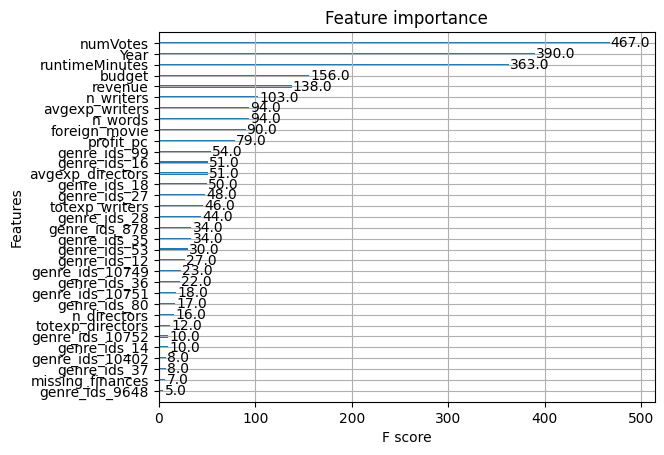

In [51]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

feature_names = X_train.drop(columns=['tconst']).columns
model = best_models['XGBoost'].named_steps['classifier']
model.get_booster().feature_names = feature_names.tolist()

# Plot feature importance
plot_importance(model, importance_type='weight')
plt.show()


In [52]:
# Load hidden validation and test sets and run through best performing prediction model
# TODO: Tidy this bit up

validation_data = con.execute('''
    SELECT tconst,
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(primaryTitle)), 'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS pTitle,
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(originalTitle)),'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS oTitle,
        CASE
           WHEN oTitle IS NULL THEN 0
           ELSE 1
        END AS ForeignFilm,
        LENGTH(pTitle) - LENGTH(REPLACE(pTitle, ' ', '')) + 1 AS n_words,
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS Year,
        runtimeMinutes,
        numVotes
        FROM 'big-data-course-2024-projects/imdb/validation_hidden.csv'
    ''').df().replace('\\N',np.nan)

test_data = con.execute('''
    SELECT tconst,
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(primaryTitle)), 'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS pTitle,
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(originalTitle)),'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS oTitle,
        CASE
           WHEN oTitle IS NULL THEN 0
           ELSE 1
        END AS ForeignFilm,
        LENGTH(pTitle) - LENGTH(REPLACE(pTitle, ' ', '')) + 1 AS n_words,
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS Year,
        runtimeMinutes,
        numVotes
        FROM 'big-data-course-2024-projects/imdb/test_hidden.csv'
    ''').df().replace('\\N',np.nan)

hidden_validation_data = con.execute('''
    SELECT 
      td.tconst, 
      td.Year AS Year,
      tmdb.foreign_movie,
      
      -- If runtime from IMDB is missing, use the tmdb data
      CASE
        WHEN td.runtimeMinutes LIKE '%N%' THEN CAST(tmdb.runtime AS INT)
        ELSE CAST(td.runtimeMinutes  AS INT)
      END AS runtimeMinutes,
      tmdb.genre_ids,
      
      td.n_words, 
      td.numVotes,
      e.n_writers,
      e.avgexp_writers,
      e.totexp_writers,
      e.n_directors,
      e.avgexp_directors,
      e.totexp_directors,
      
      tmdb.popularity,
      tmdb.vote_average,
      tmdb.vote_count,
      
      tmdb.budget,
      tmdb.revenue,
      tmdb.profit_pc,
      tmdb.missing_finances,
      
    FROM validation_data td
    LEFT JOIN agg_experience e ON e.tconst == td.tconst
    LEFT JOIN tmdb_data tmdb on tmdb.tconst == td.tconst
    ORDER BY td.tconst
''').df()

hidden_test_data = con.execute('''
    SELECT 
      td.tconst, 
      td.Year AS Year,
      tmdb.foreign_movie,
      
      -- If runtime from IMDB is missing, use the tmdb data
      CASE
        WHEN td.runtimeMinutes LIKE '%N%' THEN CAST(tmdb.runtime AS INT)
        ELSE CAST(td.runtimeMinutes  AS INT)
      END AS runtimeMinutes,
      tmdb.genre_ids,
      
      td.n_words, 
      td.numVotes,
      e.n_writers,
      e.avgexp_writers,
      e.totexp_writers,
      e.n_directors,
      e.avgexp_directors,
      e.totexp_directors,
      
      tmdb.popularity,
      tmdb.vote_average,
      tmdb.vote_count,
      
      tmdb.budget,
      tmdb.revenue,
      tmdb.profit_pc,
      tmdb.missing_finances,
      
    FROM test_data td
    LEFT JOIN agg_experience e ON e.tconst == td.tconst
    LEFT JOIN tmdb_data tmdb on tmdb.tconst == td.tconst
    ORDER BY td.tconst
''').df()


In [53]:
# OHE the validation and test sets

# Explode the genre_ids column
vexploded_genre = hidden_validation_data[['tconst','genre_ids']].explode('genre_ids')
vexploded_genre['genre_ids'] = vexploded_genre['genre_ids'].astype(cat_genre)

texploded_genre = hidden_test_data[['tconst','genre_ids']].explode('genre_ids')
texploded_genre['genre_ids'] = texploded_genre['genre_ids'].astype(cat_genre)

# One-hot encode the exploded column
vohe_df = pd.get_dummies(vexploded_genre, columns=['genre_ids'])
tohe_df = pd.get_dummies(texploded_genre, columns=['genre_ids'])

# Group by the original index and sum to aggregate the one-hot encoded columns
vagg_df = vohe_df.groupby(vohe_df.index).sum()
tagg_df = tohe_df.groupby(tohe_df.index).sum()

# Merge back with the original training data
hidden_validation_data_ohe_genre = hidden_validation_data.drop('genre_ids', axis=1).merge(vagg_df.loc[:,'genre_ids_12':], left_index=True, right_index=True)
hidden_test_data_ohe_genre = hidden_test_data.drop('genre_ids', axis=1).merge(tagg_df.loc[:,'genre_ids_12':], left_index=True, right_index=True)

hidden_validation_data_ohe_genre

,tconst,Year,foreign_movie,runtimeMinutes,n_words,numVotes,n_writers,avgexp_writers,totexp_writers,n_directors,...,genre_ids_53,genre_ids_80,genre_ids_99,genre_ids_878,genre_ids_9648,genre_ids_10402,genre_ids_10749,genre_ids_10751,genre_ids_10752,genre_ids_10770
0,tt0003740,1914,1,148.0,1,3452.0,4,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0008663,1917,1,65.0,4,1882.0,3,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
2,tt0010307,1919,1,166.0,1,1692.0,1,0.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
3,tt0014429,1923,0,74.0,2,19898.0,6,0.5,1.0,2,...,1,0,0,0,0,0,1,0,0,0
4,tt0015175,1924,1,143.0,3,5676.0,2,1.5,3.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,tt9686154,2019,1,103.0,5,2106.0,3,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
951,tt9690328,2020,0,109.0,2,NaN,2,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
952,tt9735790,2021,0,98.0,3,1056.0,1,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
953,tt9769668,2021,1,145.0,2,1430.0,2,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# Choose best performing model

valid_pred = best_models['XGBoost'].predict(hidden_validation_data_ohe_genre.drop(columns=['tconst','popularity', 'vote_average', 'vote_count']))
test_pred = best_models['XGBoost'].predict(hidden_test_data_ohe_genre.drop(columns=['tconst','popularity', 'vote_average', 'vote_count']))

print (valid_pred.mean(), test_pred.mean())

# Add predicted column
hidden_validation_data_ohe_genre['pred_label'] = valid_pred
hidden_test_data_ohe_genre['pred_label'] = test_pred

# Save to test file for prediction upload
np.savetxt('valid_predictions_genre.txt', np.where(valid_pred == 1, 'True', 'False'), fmt='%s', newline='\n')
np.savetxt('test_predictions_genre.txt', np.where(test_pred == 1, 'True', 'False'), fmt='%s', newline='\n')

0.46910994764397906 0.5165745856353591


In [55]:
# Validate that the labels match up with the correct movie title (in case order has been messed around)

df_valid = pd.read_csv('big-data-course-2024-projects/imdb/validation_hidden.csv')
df_test = pd.read_csv('big-data-course-2024-projects/imdb/test_hidden.csv')

print ((df_valid['tconst'] == hidden_validation_data_ohe_genre['tconst']).all(),
       (df_test['tconst'] == hidden_test_data_ohe_genre['tconst']).all())

True True
